In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
from typing import *
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from time import time

In [2]:
class Configs():
    def __init__(self):
        self.batch_size = 64
        self.lr = 1e-3
        self.epochs = 10
        self.print_every = 2
        self.seed = 42

device = 'cuda' if torch.cuda.is_available() else 'cpu'
configs = Configs()

In [3]:
class SplineLinear(nn.Linear):
    def __init__(
        self, 
        in_features: int, 
        out_features: int, 
        init_scale: float = 0.1, **kw
    ) -> None:
        self.init_scale = init_scale
        super().__init__(in_features, out_features, bias=False, **kw)

    def reset_parameters(self) -> None:
        nn.init.trunc_normal_(self.weight, mean=0, std=self.init_scale)

In [4]:
class RadialBasisFunction(nn.Module):
    """
    방사 기저 함수
    입력 데이터가 특정 중심점으로부터 얼마나 떨어져 있는지를 기반으로 값을 계산
    논문에서는 3차 B-스플라인을 RBF로 근사할 수 있다고 함
    """
    def __init__(
        self,
        grid_min: float = -2.0,
        grid_max: float = 2.0,
        num_grids: int = 8,
        denominator: float = None,
    ):
        super().__init__()
        self.grid_min = grid_min
        self.grid_max = grid_max
        self.num_grids = num_grids
        grid = torch.linspace(grid_min, grid_max, num_grids)
        self.grid = torch.nn.Parameter(grid, requires_grad=False)  # 입력 사이즈로 Broadcasting
        self.denominator = denominator or (grid_max - grid_min) / (num_grids - 1)

    def forward(self, x):
        """
        r : 원점으로부터 데이터까지의 거리
        h : 함수의 퍼짐 정도를 조절하는 파라미터
        """
        return torch.exp(-(((x[..., None] - self.grid) / self.denominator) ** 2))

In [5]:
class FastKANLayer(nn.Module):
    def __init__(
        self,
        input_dim: int,
        output_dim: int,
        grid_min: float = -2.0,  # RBF에서 사용할 그리드 최솟값
        grid_max: float = 2.0,  # RBF에서 사용할 그리드 최댓값
        num_grids: int = 8,  # 중심점 개수
        use_base_update: bool = True,  # 추가 선형 변환 적용
        use_layernorm: bool = True,  # layernorm 적용
        base_activation=F.silu,
        spline_weight_init_scale: float = 0.1,
    ) -> None:
        super().__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.layernorm = None
        if use_layernorm:
            assert (
                input_dim > 1
            ), "Do not use layernorms on 1D inputs. Set `use_layernorm=False`."
            self.layernorm = nn.LayerNorm(input_dim)
        self.rbf = RadialBasisFunction(grid_min, grid_max, num_grids)
        self.spline_linear = SplineLinear(
            input_dim * num_grids, output_dim, spline_weight_init_scale
        )
        self.use_base_update = use_base_update
        if use_base_update:
            self.base_activation = base_activation
            self.base_linear = nn.Linear(input_dim, output_dim)

    def forward(self, x, use_layernorm=True):
        """
        x: B, input_dim, num_grids
        """
        if self.layernorm is not None and use_layernorm:
            spline_basis = self.rbf(self.layernorm(x))  # B, input_dim, num_grids
        else:
            spline_basis = self.rbf(x)
        
        ret = self.spline_linear(spline_basis.view(*spline_basis.shape[:-2], -1))  # B, input_dim * num_grids -> B, output_dim

        if self.use_base_update:
            base = self.base_linear(self.base_activation(x))
            ret = ret + base

        return ret

In [6]:
class FastKAN(nn.Module):
    def __init__(
        self,
        layers_hidden: List[int],
        grid_min: float = -2.0,
        grid_max: float = 2.0,
        num_grids: int = 8,
        use_base_update: bool = True,
        base_activation=F.silu,
        spline_weight_init_scale: float = 0.1,
    ) -> None:
        super().__init__()
        self.layers = nn.ModuleList(
            [
                FastKANLayer(
                    in_dim,
                    out_dim,
                    grid_min=grid_min,
                    grid_max=grid_max,
                    num_grids=num_grids,
                    use_base_update=use_base_update,
                    base_activation=base_activation,
                    spline_weight_init_scale=spline_weight_init_scale,
                )
                for in_dim, out_dim in zip(layers_hidden[:-1], layers_hidden[1:])
            ]
        )

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

In [7]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
train_loader = DataLoader(
    trainset, 
    batch_size=configs.batch_size,
    shuffle=True, 
    num_workers=4,
    )

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
test_loader = DataLoader(
    testset, 
    batch_size=configs.batch_size,
    shuffle=False, num_workers=4,
    )

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [8]:
class KANCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = FastKAN([64 * 8 * 8, 256])
        self.fc2 = FastKAN([256, 10])

    def forward(self, x):
        x = self.pool(F.selu(self.conv1(x)))
        x = self.pool(F.selu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.fc2(x)
        return x
    
    
class LinearCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 8 * 8, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.pool(F.selu(self.conv1(x)))
        x = self.pool(F.selu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.fc2(x)
        return x

In [9]:
model_dict = {
    'kan': KANCNN(),
    'linear': LinearCNN(),
}

optimizer_dict = {
    'kan': optim.AdamW(model_dict['kan'].parameters(), lr=configs.lr),
    'linear': optim.AdamW(model_dict['linear'].parameters(), lr=configs.lr),
}

criterion = nn.CrossEntropyLoss()

In [10]:
def evaluate(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    eval_loss = 0.0

    with torch.no_grad():
        for batch in test_loader:
            inputs = batch[0].to(device)
            labels = batch[1].to(device)

            outputs = model(inputs)
            loss =criterion(outputs, labels)

            eval_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    return eval_loss / len(test_loader), correct / total
            

def train(model, train_loader, optimizer):
    model.train()
    correct = 0
    total = 0
    train_loss = 0.0

    for batch in train_loader:
        inputs = batch[0].to(device)
        labels = batch[1].to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    return train_loss / len(train_loader), correct / total

In [11]:
metrics_history = {
    'kan':{
        'train_loss': [],
        'train_accuracy': [],
        'test_loss': [],
        'test_accuracy': [],
    },
    'linear':{
        'train_loss': [],
        'train_accuracy': [],
        'test_loss': [],
        'test_accuracy': [],
    },
}

In [12]:
for model_type in ['kan', 'linear']:
    start_time = time()

    model = model_dict[model_type]
    optimizer = optimizer_dict[model_type]
    model = model.to(device)

    for epoch in range(configs.epochs):
        train_loss, train_acc = train(model, train_loader, optimizer)

        if epoch % configs.print_every == 0:
            test_loss, test_acc = evaluate(model, test_loader)

            metrics_history[model_type]['train_loss'].append(train_loss)
            metrics_history[model_type]['train_accuracy'].append(train_acc)
            metrics_history[model_type]['test_loss'].append(test_loss)
            metrics_history[model_type]['test_accuracy'].append(test_acc)

            print(
                f"[{model_type}] "
                f"epoch: {epoch}, "
                f"train_loss: {metrics_history[model_type]['train_loss'][-1]:.4f}, "
                f"train_accuracy: {metrics_history[model_type]['train_accuracy'][-1] * 100:.4f}, "
                f"test_loss: {metrics_history[model_type]['test_loss'][-1]:.4f}, "
                f"test_accuracy: {metrics_history[model_type]['test_accuracy'][-1] * 100:.4f} "
            )

    end_time = time()
    total_time = end_time - start_time
    print(f'{model_type} model elapsed time: {total_time:.2f}sec')

[kan] epoch: 0, train_loss: 23.0189, train_accuracy: 12.1020, test_loss: 31.3095, test_accuracy: 11.9400 
[kan] epoch: 2, train_loss: 58.7830, train_accuracy: 13.0480, test_loss: 35.4182, test_accuracy: 11.6600 
[kan] epoch: 4, train_loss: 72.2728, train_accuracy: 12.2960, test_loss: 21.1932, test_accuracy: 11.0300 
[kan] epoch: 6, train_loss: 27.9874, train_accuracy: 12.6020, test_loss: 18.2669, test_accuracy: 14.9700 
[kan] epoch: 8, train_loss: 172.1671, train_accuracy: 11.8440, test_loss: 11.9819, test_accuracy: 13.6500 
kan model elapsed time: 306.64sec
[linear] epoch: 0, train_loss: 5990.2219, train_accuracy: 12.6500, test_loss: 22938.6110, test_accuracy: 10.0000 
[linear] epoch: 2, train_loss: 91946.1454, train_accuracy: 10.1940, test_loss: 117913.3044, test_accuracy: 10.0000 
[linear] epoch: 4, train_loss: 173576.2532, train_accuracy: 9.9440, test_loss: 199751.6267, test_accuracy: 10.0000 
[linear] epoch: 6, train_loss: 244727.6657, train_accuracy: 10.2160, test_loss: 300493.69

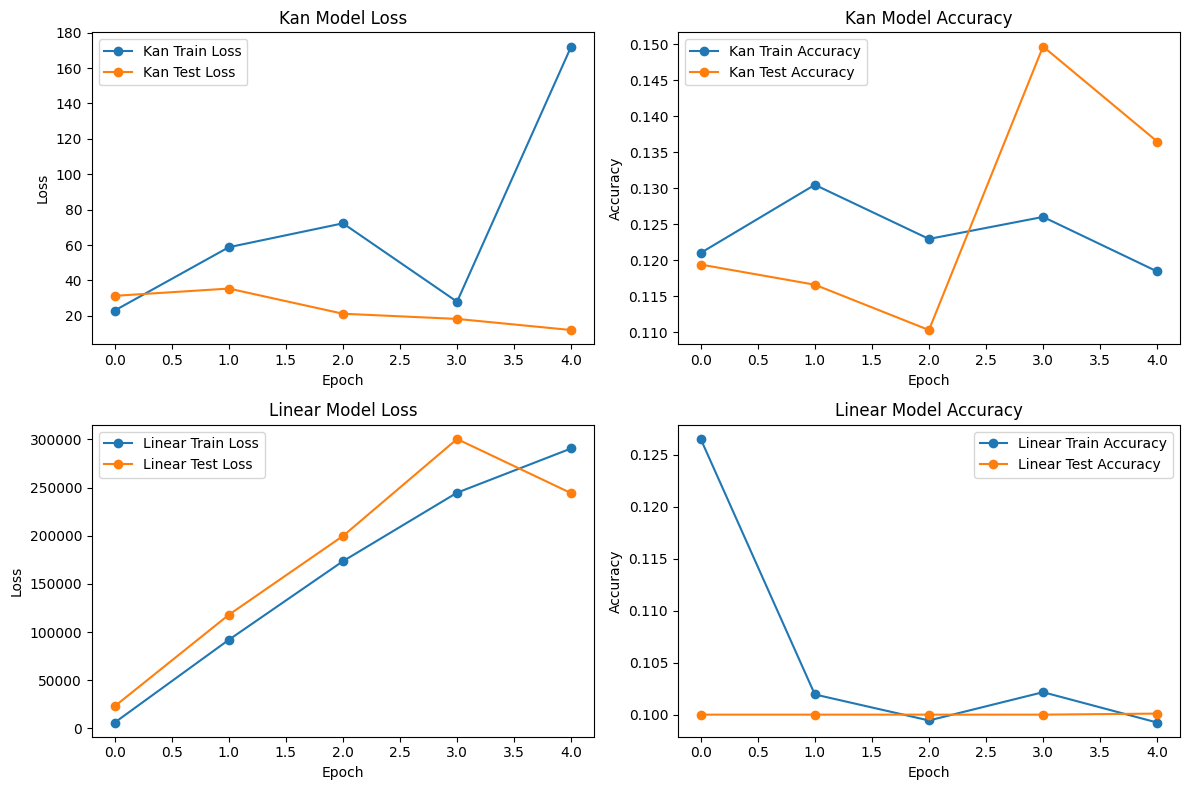

In [13]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8))


axs[0, 0].plot(metrics_history['kan']['train_loss'], marker='o', label='Kan Train Loss')
axs[0, 0].plot(metrics_history['kan']['test_loss'], marker='o', label='Kan Test Loss')
axs[0, 0].set_title('Kan Model Loss')
axs[0, 0].set_xlabel('Epoch')
axs[0, 0].set_ylabel('Loss')
axs[0, 0].legend()

axs[0, 1].plot(metrics_history['kan']['train_accuracy'], marker='o', label='Kan Train Accuracy')
axs[0, 1].plot(metrics_history['kan']['test_accuracy'], marker='o', label='Kan Test Accuracy')
axs[0, 1].set_title('Kan Model Accuracy')
axs[0, 1].set_xlabel('Epoch')
axs[0, 1].set_ylabel('Accuracy')
axs[0, 1].legend()

axs[1, 0].plot(metrics_history['linear']['train_loss'], marker='o', label='Linear Train Loss')
axs[1, 0].plot(metrics_history['linear']['test_loss'], marker='o', label='Linear Test Loss')
axs[1, 0].set_title('Linear Model Loss')
axs[1, 0].set_xlabel('Epoch')
axs[1, 0].set_ylabel('Loss')
axs[1, 0].legend()

axs[1, 1].plot(metrics_history['linear']['train_accuracy'], marker='o', label='Linear Train Accuracy')
axs[1, 1].plot(metrics_history['linear']['test_accuracy'], marker='o', label='Linear Test Accuracy')
axs[1, 1].set_title('Linear Model Accuracy')
axs[1, 1].set_xlabel('Epoch')
axs[1, 1].set_ylabel('Accuracy')
axs[1, 1].legend()

plt.tight_layout()
plt.show()

In [14]:
for model_type in ['kan', 'linear']:

    correct_pred = {classname: 0 for classname in classes}
    total_pred = {classname: 0 for classname in classes}

    for batch in test_loader:
        images = batch[0].to(device)
        labels = batch[1].to(device)
        outputs = model_dict[model_type](images)
        _, predictions = torch.max(outputs, 1)

        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


    for classname, correct_count in correct_pred.items():
        accuracy = 100 * float(correct_count) / total_pred[classname]
        print(f'Accuracy for [{model_type}] class {classname:5s} : {accuracy:.1f} %')

Accuracy for [kan] class plane : 31.7 %
Accuracy for [kan] class car   : 18.5 %
Accuracy for [kan] class bird  : 5.3 %
Accuracy for [kan] class cat   : 4.4 %
Accuracy for [kan] class deer  : 32.2 %
Accuracy for [kan] class dog   : 4.3 %
Accuracy for [kan] class frog  : 0.0 %
Accuracy for [kan] class horse : 0.4 %
Accuracy for [kan] class ship  : 46.5 %
Accuracy for [kan] class truck : 0.0 %
Accuracy for [linear] class plane : 0.0 %
Accuracy for [linear] class car   : 0.0 %
Accuracy for [linear] class bird  : 0.0 %
Accuracy for [linear] class cat   : 0.0 %
Accuracy for [linear] class deer  : 0.0 %
Accuracy for [linear] class dog   : 0.0 %
Accuracy for [linear] class frog  : 0.0 %
Accuracy for [linear] class horse : 100.0 %
Accuracy for [linear] class ship  : 0.0 %
Accuracy for [linear] class truck : 0.0 %
